# Initial tinkering with E. coli iModulon data to see if we can train a CNN to learn M-matrix values

In [59]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch

In [21]:
import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import r2_score

from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping,Checkpoint
from skorch.dataset import Dataset
from skorch.helper import predefined_split


## Load data

In [9]:
# locus_info_filename = 'data/locus2info.tsv'
# locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
# locus2info = u.make_info_dict(locus_info_df)

# log_data_filename = "data/XY_logTPM_opFilt.tsv"
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')

display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
0,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0.008229,-0.000685,-0.005215,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
1,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0.008111,-0.003929,0.003207,...,-0.000337,-0.010468,0.016122,0.010361,-0.003899,-0.022839,-0.003665,-0.001823,-0.023604,-0.012765
2,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0.008629,-0.001270,-0.005664,...,0.000394,0.007215,-0.000707,-0.012959,-0.002329,0.006391,-0.003650,-0.008537,0.002898,-0.000891
3,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0.002952,0.002053,-0.002882,...,-0.009291,-0.000226,0.016013,0.002179,0.004891,-0.002365,-0.003490,-0.006066,-0.011982,0.011477
4,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0.006142,0.000884,0.008166,...,-0.009214,-0.010588,0.001363,0.003979,-0.005208,0.003190,-0.015137,-0.005784,-0.001302,0.010800


TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [8]:
'b3575' in set(XY['locus_tag'].values)

True

In [10]:
def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

In [11]:
# Split data into train/test/split here and now
full_train_df,test_df = tu.quick_split(XY)
train_df, val_df = tu.quick_split(full_train_df)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)


# coi = "NoCu"
# assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])
# view_train_test_dist(train_df, test_df,[coi],"log(TPM)",val_df=val_df)

(1703, 100)
(426, 100)
(1362, 101)
(341, 101)


## convert to skorch-able dfs

In [15]:
# get iModulon column labels
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = M.columns
imods[:5]

Index(['0', '1', '2', '3', '4'], dtype='object')

In [16]:
def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [17]:
Xtrain, ytrain = make_mt_skorch_dfs(train_df, seq_col="upstream_region",target_cols=imods)
print("\nXtrain:",Xtrain.shape)
print("ytrain:",ytrain.shape)

Xval, yval = make_mt_skorch_dfs(val_df, seq_col="upstream_region",target_cols=imods)
print("\nXval:",Xval.shape)
print("yval:",yval.shape)

Xtest, ytest = make_mt_skorch_dfs(test_df, seq_col="upstream_region",target_cols=imods)
print("\nXtest:",Xtest.shape)
print("ytest:",ytest.shape)

Xfull_train, yfull_train = make_mt_skorch_dfs(full_train_df, seq_col="upstream_region",target_cols=imods)
print("\nXfull_train:",Xfull_train.shape)
print("yfull_train:",yfull_train.shape)


Xtrain: torch.Size([1362, 300, 4])
ytrain: torch.Size([1362, 92])

Xval: torch.Size([341, 300, 4])
yval: torch.Size([341, 92])

Xtest: torch.Size([426, 300, 4])
ytest: torch.Size([426, 92])

Xfull_train: torch.Size([1703, 300, 4])
yfull_train: torch.Size([1703, 92])


In [22]:
# make skorch predefined valid ds
valid_ds = Dataset(Xval, yval)

## pick some params

In [20]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [25]:
# just pick some
# Adam, 32 filt, fast LR
net_regr1 = NeuralNetRegressor(
    m.DNA_2CNN_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=128,
    module__kernel_size1=6,
    module__kernel_size2=16,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.0,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.RMSprop,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr2 = NeuralNetRegressor(
    m.DNA_2CNN_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=64,
    module__num_filters2=32,
    module__kernel_size1=6,
    module__kernel_size2=16,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 50,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.RMSprop,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

In [26]:
net_regr1.fit(Xtrain, ytrain)
net_regr2.fit(Xtrain, ytrain)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1       25.4270        0.0035     +  3.2393
      2        0.0034        0.0034     +  0.2126
      3        0.0033        0.0033     +  0.2116
      4        0.0033        0.0032     +  0.2101
      5        0.0053        0.0032     +  0.2113
      6        0.0031        0.0031     +  0.2111
      7        0.0031        0.0031     +  0.2107
      8        0.0030        0.0030     +  0.2121
      9        0.0029        0.0029     +  0.2105
     10        0.0029        0.0029     +  0.2119
     11        0.0028        0.0028     +  0.2119
     12        0.0027        0.0027     +  0.2117
     13        0.0027        0.0027     +  0.2118
     14        0.0026        0.0026     +  0.2109
     15        0.0025        0.0025     +  0.2124
     16        0.0025        0.0025     +  0.2124
     17        0.0024        0.0024     +  0.2111
     18        0.0023        0.0023     +  0.2109


    135        0.0003        0.0003        0.2143
    136        0.0003        0.0003        0.2142
    137        0.0003        0.0003        0.2142
    138        0.0003        0.0003        0.2126
    139        0.0003        0.0003        0.2149
    140        0.0003        0.0003        0.2133
    141        0.0003        0.0003        0.2149
    142        0.0003        0.0003        0.2149
    143        0.0003        0.0003        0.2158
    144        0.0003        0.0003        0.2134
    145        0.0003        0.0003        0.2131
    146        0.0003        0.0003        0.2139
    147        0.0003        0.0003        0.2165
    148        0.0003        0.0003        0.2139
    149        0.0003        0.0003        0.2129
    150        0.0003        0.0003        0.2153
    151        0.0003        0.0003     +  0.2159
    152        0.0003        0.0003        0.2118
    153        0.0003        0.0003     +  0.2131
    154        0.0003        0.0003        0.2125


    288        0.0002        0.0003        0.2151
    289        0.0002        0.0003        0.2141
    290        0.0002        0.0003        0.2136
    291        0.0002        0.0003        0.2175
    292        0.0002        0.0003        0.2158
    293        0.0002        0.0003        0.2135
    294        0.0002        0.0003        0.2135
    295        0.0002        0.0003        0.2132
    296        0.0002        0.0003        0.2132
    297        0.0002        0.0003        0.2130
    298        0.0002        0.0003        0.2141
    299        0.0002        0.0003        0.2143
    300        0.0002        0.0003        0.2134
    301        0.0002        0.0003        0.2145
    302        0.0002        0.0003        0.2135
    303        0.0002        0.0003        0.2134
    304        0.0002        0.0003        0.2159
    305        0.0002        0.0003        0.2142
    306        0.0002        0.0003        0.2138
    307        0.0002        0.0003        0.2129


    435        0.0001        0.0003        0.2164
    436        0.0001        0.0003        0.2146
    437        0.0001        0.0003        0.2140
    438        0.0001        0.0003        0.2151
    439        0.0001        0.0003        0.2162
    440        0.0001        0.0003        0.2139
    441        0.0001        0.0003        0.2138
    442        0.0001        0.0003        0.2150
    443        0.0001        0.0003        0.2157
    444        0.0001        0.0003        0.2150
    445        0.0001        0.0003        0.2148
    446        0.0001        0.0003        0.2159
    447        0.0001        0.0003        0.2139
    448        0.0001        0.0003        0.2153
    449        0.0001        0.0003        0.2157
    450        0.0001        0.0003        0.2148
    451        0.0001        0.0003        0.2140
    452        0.0001        0.0004        0.2156
    453        0.0001        0.0003        0.2166
    454        0.0001        0.0003        0.2155


    585        0.0001        0.0003        0.2148
    586        0.0001        0.0003        0.2164
    587        0.0001        0.0003        0.2161
    588        0.0001        0.0003        0.2150
    589        0.0001        0.0003        0.2173
    590        0.0001        0.0003        0.2152
    591        0.0001        0.0003        0.2170
    592        0.0001        0.0004        0.2168
    593        0.0001        0.0003        0.2167
    594        0.0001        0.0003        0.2158
    595        0.0001        0.0003        0.2155
    596        0.0001        0.0003        0.2162
    597        0.0001        0.0003        0.2174
    598        0.0001        0.0003        0.2156
    599        0.0001        0.0003        0.2154
    600        0.0001        0.0003        0.2169
    601        0.0001        0.0003        0.2179
    602        0.0001        0.0003        0.2200
    603        0.0001        0.0004        0.2169
    604        0.0001        0.0004        0.2163


      5        0.0004        0.0004        0.1191
      6        0.0004        0.0005        0.1197
      7        0.0004        0.0003     +  0.1206
      8        0.0004        0.0005        0.1210
      9        0.0004        0.0003        0.1207
     10        0.0003        0.0004        0.1203
     11        0.0004        0.0003     +  0.1210
     12        0.0004        0.0004        0.1184
     13        0.0003        0.0003     +  0.1202
     14        0.0004        0.0007        0.1186
     15        0.0005        0.0003     +  0.1203
     16        0.0004        0.0004        0.1209
     17        0.0004        0.0003        0.1222
     18        0.0004        0.0004        0.1204
     19        0.0004        0.0003     +  0.1208
     20        0.0004        0.0004        0.1198
     21        0.0003        0.0003     +  0.1203
     22        0.0004        0.0006        0.1191
     23        0.0004        0.0003        0.1202
     24        0.0004        0.0005        0.1187


    159        0.0003        0.0003        0.1199
    160        0.0003        0.0003        0.1202
    161        0.0003        0.0003        0.1207
    162        0.0003        0.0003        0.1200
    163        0.0003        0.0003        0.1211
    164        0.0003        0.0003        0.1200
    165        0.0003        0.0003        0.1195
    166        0.0002        0.0003        0.1199
    167        0.0003        0.0003        0.1203
    168        0.0002        0.0003        0.1190
    169        0.0002        0.0003        0.1199
    170        0.0002        0.0003        0.1199
    171        0.0002        0.0003        0.1199
    172        0.0002        0.0003        0.1201
    173        0.0002        0.0003        0.1193
    174        0.0002        0.0003        0.1188
    175        0.0002        0.0003        0.1192
    176        0.0002        0.0003        0.1192
    177        0.0002        0.0003        0.1200
    178        0.0002        0.0003        0.1194


    314        0.0002        0.0003        0.1201
    315        0.0002        0.0003        0.1224
    316        0.0002        0.0003        0.1205
    317        0.0002        0.0003        0.1204
    318        0.0002        0.0003        0.1198
    319        0.0002        0.0003        0.1199
    320        0.0002        0.0003        0.1196
    321        0.0002        0.0003        0.1206
    322        0.0002        0.0003        0.1200
    323        0.0002        0.0003        0.1200
    324        0.0002        0.0003        0.1204
    325        0.0002        0.0003        0.1211
    326        0.0002        0.0003        0.1219
    327        0.0002        0.0003        0.1210
    328        0.0002        0.0003        0.1213
    329        0.0002        0.0003        0.1204
    330        0.0002        0.0003        0.1206
    331        0.0002        0.0003        0.1199
    332        0.0002        0.0003        0.1196
    333        0.0002        0.0003        0.1201


    470        0.0002        0.0003        0.1220
    471        0.0002        0.0003        0.1218
    472        0.0002        0.0003        0.1221
    473        0.0002        0.0003        0.1217
    474        0.0002        0.0003        0.1205
    475        0.0002        0.0003        0.1199
    476        0.0002        0.0003        0.1204
    477        0.0002        0.0003        0.1209
    478        0.0002        0.0003        0.1201
    479        0.0002        0.0003        0.1209
    480        0.0002        0.0003        0.1215
    481        0.0002        0.0003        0.1219
    482        0.0002        0.0003        0.1211
    483        0.0002        0.0003        0.1214
    484        0.0002        0.0003        0.1205
    485        0.0002        0.0003        0.1216
    486        0.0002        0.0003        0.1202
    487        0.0002        0.0003        0.1212
    488        0.0002        0.0003        0.1202
    489        0.0002        0.0003        0.1223


Stopping since valid_loss has not improved in the last 500 epochs.


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 6), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(64, 32, kernel_size=(1, 16), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=2656, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=92, bias=True)
    )
  ),
)

In [27]:
net_regr3 = NeuralNetRegressor(
    m.DNA_2CNN_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=8,
    module__kernel_size2=16,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 10,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.5,
    max_epochs=5000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=1000),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.RMSprop,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr3.fit(Xtrain,ytrain)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0591        0.0273     +  0.0526
      2        0.0253        0.0223     +  0.0506
      3        0.0205        0.0186     +  0.0504
      4        0.0178        0.0163     +  0.0504
      5        0.0157        0.0144     +  0.0504
      6        0.0139        0.0127     +  0.0503
      7        0.0123        0.0112     +  0.0498
      8        0.0109        0.0100     +  0.0501
      9        0.0097        0.0088     +  0.0501
     10        0.0086        0.0078     +  0.0502
     11        0.0077        0.0069     +  0.0503
     12        0.0068        0.0062     +  0.0503
     13        0.0060        0.0054     +  0.0503
     14        0.0054        0.0048     +  0.0501
     15        0.0049        0.0044     +  0.0498
     16        0.0043        0.0037     +  0.0498
     17        0.0038        0.0033     +  0.0499
     18        0.0033        0.0031     +  0.0501


    146        0.0003        0.0003        0.0500
    147        0.0003        0.0003        0.0500
    148        0.0003        0.0003        0.0495
    149        0.0003        0.0003        0.0504
    150        0.0003        0.0003        0.0501
    151        0.0003        0.0003        0.0500
    152        0.0003        0.0003        0.0502
    153        0.0003        0.0003        0.0506
    154        0.0003        0.0003        0.0503
    155        0.0003        0.0003        0.0508
    156        0.0003        0.0003        0.0508
    157        0.0003        0.0003        0.0503
    158        0.0003        0.0003        0.0501
    159        0.0003        0.0003        0.0500
    160        0.0003        0.0003        0.0503
    161        0.0003        0.0003        0.0504
    162        0.0003        0.0003     +  0.0499
    163        0.0003        0.0003        0.0509
    164        0.0003        0.0003        0.0515
    165        0.0003        0.0003        0.0509


    295        0.0002        0.0003        0.0505
    296        0.0002        0.0003        0.0508
    297        0.0002        0.0003        0.0510
    298        0.0002        0.0003        0.0506
    299        0.0002        0.0003        0.0507
    300        0.0002        0.0003        0.0510
    301        0.0002        0.0003        0.0507
    302        0.0002        0.0003        0.0509
    303        0.0002        0.0003        0.0512
    304        0.0002        0.0003        0.0506
    305        0.0002        0.0003        0.0505
    306        0.0002        0.0003        0.0513
    307        0.0002        0.0003        0.0508
    308        0.0002        0.0003        0.0506
    309        0.0002        0.0003        0.0504
    310        0.0002        0.0003        0.0504
    311        0.0002        0.0003        0.0507
    312        0.0002        0.0003        0.0510
    313        0.0002        0.0003        0.0508
    314        0.0002        0.0003        0.0505


    448        0.0002        0.0003        0.0502
    449        0.0002        0.0003        0.0498
    450        0.0002        0.0003        0.0499
    451        0.0002        0.0003        0.0498
    452        0.0002        0.0003        0.0498
    453        0.0002        0.0003        0.0499
    454        0.0002        0.0003        0.0500
    455        0.0002        0.0003        0.0509
    456        0.0002        0.0003        0.0509
    457        0.0002        0.0003        0.0509
    458        0.0002        0.0003        0.0505
    459        0.0002        0.0003        0.0509
    460        0.0002        0.0003        0.0524
    461        0.0002        0.0003        0.0512
    462        0.0002        0.0003        0.0515
    463        0.0002        0.0003        0.0515
    464        0.0002        0.0003        0.0514
    465        0.0002        0.0003        0.0516
    466        0.0002        0.0003        0.0509
    467        0.0002        0.0003        0.0512


    607        0.0002        0.0003        0.0504
    608        0.0002        0.0003        0.0500
    609        0.0002        0.0003        0.0499
    610        0.0002        0.0003        0.0509
    611        0.0002        0.0003        0.0513
    612        0.0002        0.0003        0.0510
    613        0.0002        0.0003        0.0517
    614        0.0002        0.0003        0.0516
    615        0.0002        0.0003        0.0516
    616        0.0002        0.0003        0.0519
    617        0.0002        0.0003        0.0516
    618        0.0002        0.0003        0.0510
    619        0.0002        0.0003        0.0516
    620        0.0002        0.0003        0.0511
    621        0.0002        0.0003        0.0514
    622        0.0002        0.0003        0.0511
    623        0.0002        0.0003        0.0512
    624        0.0002        0.0003        0.0503
    625        0.0002        0.0003        0.0505
    626        0.0002        0.0003        0.0510


    770        0.0002        0.0003        0.0507
    771        0.0002        0.0003        0.0503
    772        0.0002        0.0003        0.0506
    773        0.0002        0.0003        0.0505
    774        0.0002        0.0003        0.0501
    775        0.0002        0.0003        0.0501
    776        0.0002        0.0003        0.0502
    777        0.0002        0.0003        0.0502
    778        0.0002        0.0003        0.0501
    779        0.0002        0.0003        0.0506
    780        0.0002        0.0003        0.0508
    781        0.0002        0.0003        0.0501
    782        0.0002        0.0003        0.0501
    783        0.0002        0.0003        0.0507
    784        0.0002        0.0003        0.0508
    785        0.0002        0.0003        0.0501
    786        0.0002        0.0003        0.0507
    787        0.0002        0.0003        0.0506
    788        0.0002        0.0003        0.0504
    789        0.0002        0.0003        0.0504


    933        0.0002        0.0003        0.0505
    934        0.0002        0.0003        0.0507
    935        0.0002        0.0003        0.0500
    936        0.0002        0.0003        0.0505
    937        0.0002        0.0003        0.0502
    938        0.0002        0.0003        0.0505
    939        0.0002        0.0003        0.0508
    940        0.0002        0.0003        0.0512
    941        0.0002        0.0003        0.0508
    942        0.0002        0.0003        0.0506
    943        0.0002        0.0003        0.0498
    944        0.0002        0.0003        0.0506
    945        0.0002        0.0003        0.0505
    946        0.0002        0.0003        0.0506
    947        0.0002        0.0003        0.0514
    948        0.0002        0.0003        0.0510
    949        0.0002        0.0003        0.0509
    950        0.0002        0.0003        0.0506
    951        0.0002        0.0003        0.0508
    952        0.0002        0.0003        0.0502


   1096        0.0002        0.0003        0.0503
   1097        0.0002        0.0003        0.0503
   1098        0.0002        0.0003        0.0507
   1099        0.0002        0.0003        0.0505
   1100        0.0002        0.0003        0.0506
   1101        0.0002        0.0003        0.0508
   1102        0.0002        0.0003        0.0506
   1103        0.0002        0.0003        0.0504
   1104        0.0002        0.0003        0.0505
   1105        0.0002        0.0003        0.0503
   1106        0.0002        0.0003        0.0501
   1107        0.0002        0.0003        0.0504
   1108        0.0002        0.0003        0.0505
   1109        0.0002        0.0003        0.0502
   1110        0.0002        0.0003        0.0503
   1111        0.0002        0.0003        0.0506
   1112        0.0002        0.0003        0.0504
   1113        0.0002        0.0003        0.0503
   1114        0.0002        0.0003        0.0504
   1115        0.0002        0.0003        0.0502


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=2624, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=92, bias=True)
    )
  ),
)

In [28]:
net_regr4 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=16,
    module__kernel_size2=32,
    module__conv_pool_size1=6, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 10,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.5,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.AdamW,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr4.fit(Xtrain,ytrain)

final linear_node_num: 512
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0124        0.0007     +  0.0559
      2        0.0047        0.0014        0.0463
      3        0.0031        0.0015        0.0455
      4        0.0023        0.0014        0.0455


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([128, 92])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([82, 92])) that is different to the input size (torch.Size([82, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([85, 92])) that is different to the input size (torch.Size([85, 1])). This will likely lead to incorrect results due

      5        0.0020        0.0012        0.0454
      6        0.0018        0.0019        0.0453
      7        0.0016        0.0011        0.0454
      8        0.0015        0.0011        0.0451
      9        0.0014        0.0014        0.0450
     10        0.0013        0.0009        0.0452
     11        0.0012        0.0014        0.0452
     12        0.0011        0.0015        0.0456
     13        0.0012        0.0013        0.0453
     14        0.0011        0.0010        0.0454
     15        0.0010        0.0009        0.0452
     16        0.0010        0.0005     +  0.0456
     17        0.0010        0.0012        0.0459
     18        0.0010        0.0014        0.0455
     19        0.0010        0.0008        0.0461
     20        0.0009        0.0006        0.0456
     21        0.0009        0.0005        0.0458
     22        0.0009        0.0006        0.0455
     23        0.0009        0.0007        0.0457
     24        0.0008        0.0005     +  0.0455


    152        0.0003        0.0003        0.0447
    153        0.0003        0.0003        0.0447
    154        0.0003        0.0003        0.0450
    155        0.0003        0.0003     +  0.0447
    156        0.0003        0.0003        0.0448
    157        0.0003        0.0003        0.0449
    158        0.0003        0.0003        0.0448
    159        0.0003        0.0003        0.0446
    160        0.0003        0.0003        0.0450
    161        0.0003        0.0003        0.0450
    162        0.0003        0.0003        0.0447
    163        0.0003        0.0003     +  0.0451
    164        0.0003        0.0003        0.0457
    165        0.0003        0.0003        0.0454
    166        0.0003        0.0003        0.0448
    167        0.0003        0.0003        0.0450
    168        0.0003        0.0003        0.0452
    169        0.0003        0.0003        0.0449
    170        0.0003        0.0003     +  0.0453
    171        0.0003        0.0003        0.0454


    298        0.0003        0.0003        0.0459
    299        0.0003        0.0003        0.0456
    300        0.0003        0.0003        0.0458
    301        0.0003        0.0003        0.0460
    302        0.0003        0.0003        0.0455
    303        0.0003        0.0003        0.0454
    304        0.0003        0.0003        0.0452
    305        0.0003        0.0003        0.0454
    306        0.0003        0.0003        0.0452
    307        0.0003        0.0003        0.0452
    308        0.0003        0.0003        0.0458
    309        0.0003        0.0003        0.0455
    310        0.0003        0.0003        0.0455
    311        0.0003        0.0003        0.0458
    312        0.0003        0.0003        0.0457
    313        0.0003        0.0003        0.0456
    314        0.0003        0.0003        0.0459
    315        0.0003        0.0003        0.0455
    316        0.0003        0.0003        0.0451
    317        0.0003        0.0003        0.0451


    461        0.0003        0.0003        0.0456
    462        0.0003        0.0003        0.0457
    463        0.0003        0.0003        0.0461
    464        0.0003        0.0003        0.0459
    465        0.0003        0.0003        0.0460
    466        0.0003        0.0003        0.0456
    467        0.0003        0.0003        0.0457
    468        0.0003        0.0003        0.0460
    469        0.0003        0.0003        0.0455
    470        0.0003        0.0003        0.0453
    471        0.0003        0.0003        0.0454
    472        0.0003        0.0003        0.0454
    473        0.0003        0.0003        0.0461
    474        0.0003        0.0003        0.0466
    475        0.0003        0.0003        0.0463
    476        0.0003        0.0003        0.0459
    477        0.0003        0.0003        0.0462
    478        0.0003        0.0003        0.0461
    479        0.0003        0.0003        0.0463
    480        0.0003        0.0003        0.0467


    625        0.0003        0.0003        0.0457
    626        0.0003        0.0003        0.0451
    627        0.0003        0.0003        0.0450
    628        0.0003        0.0003        0.0456
    629        0.0003        0.0003        0.0453
    630        0.0003        0.0003        0.0454
    631        0.0003        0.0003        0.0458
    632        0.0003        0.0003        0.0453
    633        0.0003        0.0003        0.0458
    634        0.0003        0.0003        0.0454
    635        0.0003        0.0003        0.0454
    636        0.0003        0.0003        0.0454
    637        0.0003        0.0003        0.0449
    638        0.0003        0.0003        0.0448
    639        0.0003        0.0003        0.0452
    640        0.0003        0.0003        0.0452
    641        0.0003        0.0003        0.0467
    642        0.0003        0.0003        0.0460
    643        0.0003        0.0003        0.0461
    644        0.0003        0.0003        0.0455


    788        0.0003        0.0003        0.0463
    789        0.0003        0.0003        0.0457
    790        0.0003        0.0003        0.0454
    791        0.0003        0.0003        0.0455
    792        0.0003        0.0003        0.0459
    793        0.0003        0.0003        0.0463
    794        0.0003        0.0003        0.0463
    795        0.0003        0.0003        0.0462
    796        0.0003        0.0003        0.0461
    797        0.0003        0.0003        0.0469
    798        0.0003        0.0003        0.0466
    799        0.0003        0.0003        0.0467
    800        0.0003        0.0003        0.0469
    801        0.0003        0.0003        0.0460
    802        0.0003        0.0003        0.0458
    803        0.0003        0.0003        0.0467
    804        0.0003        0.0003        0.0466
    805        0.0003        0.0003        0.0462
    806        0.0003        0.0003        0.0463
    807        0.0003        0.0003        0.0461


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 6), stride=(1, 6), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=512, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [29]:
net_regr5 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=16,
    module__kernel_size2=32,
    module__conv_pool_size1=8, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 10,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.5,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=2000),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.AdamW,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr5.fit(Xtrain,ytrain)

final linear_node_num: 128
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0115        0.0004     +  0.0458
      2        0.0042        0.0018        0.0455
      3        0.0029        0.0006        0.0455
      4        0.0023        0.0006        0.0453
      5        0.0019        0.0005        0.0454
      6        0.0017        0.0003     +  0.0453
      7        0.0015        0.0004        0.0454
      8        0.0012        0.0004        0.0452
      9        0.0012        0.0003        0.0451
     10        0.0011        0.0004        0.0453
     11        0.0010        0.0004        0.0454
     12        0.0009        0.0004        0.0447
     13        0.0009        0.0004        0.0450
     14        0.0008        0.0005        0.0451
     15        0.0007        0.0004        0.0447
     16        0.0007        0.0004        0.0451
     17        0.0007        0.0004        0.0449
     18        0.0006  

    144        0.0003        0.0003        0.0452
    145        0.0003        0.0003        0.0450
    146        0.0003        0.0003        0.0451
    147        0.0003        0.0003        0.0453
    148        0.0003        0.0003        0.0451
    149        0.0003        0.0003        0.0449
    150        0.0003        0.0003        0.0453
    151        0.0003        0.0003        0.0451
    152        0.0003        0.0003        0.0450
    153        0.0003        0.0003        0.0451
    154        0.0003        0.0003        0.0450
    155        0.0003        0.0003        0.0451
    156        0.0003        0.0003        0.0450
    157        0.0003        0.0003        0.0451
    158        0.0003        0.0003        0.0452
    159        0.0003        0.0003        0.0450
    160        0.0003        0.0003        0.0450
    161        0.0003        0.0003        0.0453
    162        0.0003        0.0003        0.0451
    163        0.0003        0.0003        0.0455


    305        0.0003        0.0003        0.0446
    306        0.0003        0.0003        0.0447
    307        0.0003        0.0003        0.0446
    308        0.0003        0.0003        0.0445
    309        0.0003        0.0003        0.0446
    310        0.0003        0.0003        0.0443
    311        0.0003        0.0003        0.0448
    312        0.0003        0.0003        0.0448
    313        0.0003        0.0003        0.0447
    314        0.0003        0.0003        0.0445
    315        0.0003        0.0003        0.0449
    316        0.0003        0.0003        0.0451
    317        0.0003        0.0003        0.0448
    318        0.0003        0.0003        0.0446
    319        0.0003        0.0003        0.0447
    320        0.0003        0.0003        0.0450
    321        0.0003        0.0003        0.0449
    322        0.0003        0.0003        0.0447
    323        0.0003        0.0003        0.0446
    324        0.0003        0.0003        0.0444


    468        0.0003        0.0003        0.0450
    469        0.0003        0.0003        0.0448
    470        0.0003        0.0003        0.0446
    471        0.0003        0.0003        0.0446
    472        0.0003        0.0003        0.0444
    473        0.0003        0.0003        0.0449
    474        0.0003        0.0003        0.0450
    475        0.0003        0.0003        0.0451
    476        0.0003        0.0003     +  0.0447
    477        0.0003        0.0003        0.0451
    478        0.0003        0.0003        0.0449
    479        0.0003        0.0003        0.0447
    480        0.0003        0.0003        0.0448
    481        0.0003        0.0003        0.0445
    482        0.0003        0.0003     +  0.0447
    483        0.0003        0.0003        0.0461
    484        0.0003        0.0003        0.0450
    485        0.0003        0.0003        0.0463
    486        0.0003        0.0003        0.0451
    487        0.0003        0.0003        0.0448


    631        0.0003        0.0003        0.0452
    632        0.0003        0.0003        0.0453
    633        0.0003        0.0003        0.0452
    634        0.0003        0.0003        0.0452
    635        0.0003        0.0003        0.0448
    636        0.0003        0.0003        0.0446
    637        0.0003        0.0003        0.0451
    638        0.0003        0.0003        0.0446
    639        0.0003        0.0003        0.0446
    640        0.0003        0.0003        0.0451
    641        0.0003        0.0003        0.0449
    642        0.0003        0.0003        0.0449
    643        0.0003        0.0003        0.0451
    644        0.0003        0.0003        0.0450
    645        0.0003        0.0003        0.0450
    646        0.0003        0.0003        0.0449
    647        0.0003        0.0003        0.0449
    648        0.0003        0.0003        0.0452
    649        0.0003        0.0003        0.0450
    650        0.0003        0.0003        0.0450


    792        0.0003        0.0003        0.0456
    793        0.0003        0.0003        0.0453
    794        0.0003        0.0003     +  0.0457
    795        0.0003        0.0003        0.0470
    796        0.0003        0.0003        0.0458
    797        0.0003        0.0003        0.0458
    798        0.0003        0.0003        0.0460
    799        0.0003        0.0003     +  0.0455
    800        0.0003        0.0003        0.0466
    801        0.0003        0.0003        0.0452
    802        0.0003        0.0003        0.0451
    803        0.0003        0.0003        0.0450
    804        0.0003        0.0003        0.0453
    805        0.0003        0.0003        0.0455
    806        0.0003        0.0003        0.0454
    807        0.0003        0.0003        0.0453
    808        0.0003        0.0003        0.0458
    809        0.0003        0.0003        0.0459
    810        0.0003        0.0003        0.0456
    811        0.0003        0.0003        0.0456


    954        0.0003        0.0003        0.0468
    955        0.0003        0.0003        0.0457
    956        0.0003        0.0003        0.0460
    957        0.0003        0.0003        0.0465
    958        0.0003        0.0003        0.0460
    959        0.0003        0.0003        0.0458
    960        0.0003        0.0003        0.0465
    961        0.0003        0.0003        0.0459
    962        0.0003        0.0003        0.0456
    963        0.0003        0.0003        0.0464
    964        0.0003        0.0003        0.0462
    965        0.0003        0.0003        0.0468
    966        0.0003        0.0003        0.0466
    967        0.0003        0.0003        0.0462
    968        0.0003        0.0003        0.0457
    969        0.0003        0.0003        0.0461
    970        0.0003        0.0003        0.0468
    971        0.0003        0.0003        0.0463
    972        0.0003        0.0003        0.0458
    973        0.0003        0.0003        0.0466


   1117        0.0003        0.0003        0.0472
   1118        0.0003        0.0003        0.0469
   1119        0.0003        0.0003        0.0470
   1120        0.0003        0.0003        0.0470
   1121        0.0003        0.0003        0.0472
   1122        0.0003        0.0003        0.0472
   1123        0.0003        0.0003        0.0469
   1124        0.0003        0.0003        0.0468
   1125        0.0003        0.0003        0.0468
   1126        0.0003        0.0003        0.0470
   1127        0.0003        0.0003        0.0463
   1128        0.0003        0.0003        0.0467
   1129        0.0003        0.0003        0.0460
   1130        0.0003        0.0003        0.0464
   1131        0.0003        0.0003        0.0463
   1132        0.0003        0.0003        0.0467
   1133        0.0003        0.0003        0.0463
   1134        0.0003        0.0003        0.0459
   1135        0.0003        0.0003        0.0456
   1136        0.0003        0.0003        0.0463


   1276        0.0003        0.0003        0.0452
   1277        0.0003        0.0003        0.0451
   1278        0.0003        0.0003        0.0450
   1279        0.0003        0.0003        0.0451
   1280        0.0003        0.0003        0.0452
   1281        0.0003        0.0003        0.0450
   1282        0.0003        0.0003        0.0451
   1283        0.0003        0.0003        0.0452
   1284        0.0003        0.0003        0.0452
   1285        0.0003        0.0003        0.0457
   1286        0.0003        0.0003        0.0453
   1287        0.0003        0.0003        0.0458
   1288        0.0003        0.0003        0.0456
   1289        0.0003        0.0003        0.0461
   1290        0.0003        0.0003        0.0457
   1291        0.0003        0.0003        0.0457
   1292        0.0003        0.0003        0.0457
   1293        0.0003        0.0003        0.0459
   1294        0.0003        0.0003        0.0460
   1295        0.0003        0.0003        0.0460


   1436        0.0003        0.0003        0.0458
   1437        0.0003        0.0003        0.0459
   1438        0.0003        0.0003        0.0456
   1439        0.0003        0.0003        0.0455
   1440        0.0003        0.0003        0.0458
   1441        0.0003        0.0003        0.0455
   1442        0.0003        0.0003        0.0452
   1443        0.0003        0.0003        0.0449
   1444        0.0003        0.0003        0.0451
   1445        0.0003        0.0003     +  0.0451
   1446        0.0003        0.0003        0.0465
   1447        0.0003        0.0003        0.0449
   1448        0.0003        0.0003        0.0449
   1449        0.0003        0.0003        0.0455
   1450        0.0003        0.0003        0.0452
   1451        0.0003        0.0003        0.0453
   1452        0.0003        0.0003        0.0451
   1453        0.0003        0.0003        0.0451
   1454        0.0003        0.0003        0.0457
   1455        0.0003        0.0003        0.0458


   1598        0.0003        0.0003        0.0458
   1599        0.0003        0.0003        0.0459
   1600        0.0003        0.0003        0.0460
   1601        0.0003        0.0003        0.0455
   1602        0.0003        0.0003        0.0457
   1603        0.0002        0.0003        0.0459
   1604        0.0002        0.0003        0.0462
   1605        0.0002        0.0003        0.0462
   1606        0.0002        0.0003        0.0461
   1607        0.0002        0.0003        0.0459
   1608        0.0002        0.0003        0.0460
   1609        0.0003        0.0003        0.0457
   1610        0.0002        0.0003        0.0455
   1611        0.0002        0.0003        0.0459
   1612        0.0002        0.0003        0.0457
   1613        0.0002        0.0003        0.0459
   1614        0.0002        0.0003        0.0455
   1615        0.0002        0.0003        0.0453
   1616        0.0002        0.0003        0.0452
   1617        0.0002        0.0003        0.0457


   1762        0.0002        0.0003        0.0453
   1763        0.0002        0.0003        0.0451
   1764        0.0002        0.0003        0.0451
   1765        0.0002        0.0003        0.0452
   1766        0.0002        0.0003        0.0454
   1767        0.0002        0.0003        0.0461
   1768        0.0002        0.0003        0.0461
   1769        0.0002        0.0003        0.0454
   1770        0.0002        0.0003        0.0455
   1771        0.0002        0.0003        0.0457
   1772        0.0002        0.0003        0.0453
   1773        0.0002        0.0003        0.0453
   1774        0.0002        0.0003        0.0454
   1775        0.0002        0.0003        0.0453
   1776        0.0002        0.0003        0.0465
   1777        0.0002        0.0003        0.0458
   1778        0.0002        0.0003        0.0472
   1779        0.0002        0.0003        0.0459
   1780        0.0002        0.0003        0.0462
   1781        0.0002        0.0003        0.0461


   1925        0.0002        0.0003        0.0459
   1926        0.0002        0.0003        0.0463
   1927        0.0002        0.0003        0.0458
   1928        0.0002        0.0003        0.0459
   1929        0.0002        0.0003        0.0460
   1930        0.0002        0.0003        0.0460
   1931        0.0002        0.0003        0.0460
   1932        0.0002        0.0003        0.0458
   1933        0.0002        0.0003        0.0462
   1934        0.0002        0.0003        0.0463
   1935        0.0002        0.0003        0.0462
   1936        0.0002        0.0003        0.0459
   1937        0.0002        0.0003        0.0457
   1938        0.0002        0.0003        0.0459
   1939        0.0002        0.0003        0.0459
   1940        0.0002        0.0003        0.0459
   1941        0.0002        0.0003        0.0462
   1942        0.0002        0.0003        0.0462
   1943        0.0002        0.0003        0.0462
   1944        0.0002        0.0003        0.0461


   2089        0.0002        0.0003        0.0464
   2090        0.0002        0.0003        0.0465
   2091        0.0002        0.0003        0.0469
   2092        0.0002        0.0003        0.0465
   2093        0.0002        0.0003        0.0462
   2094        0.0002        0.0003        0.0461
   2095        0.0002        0.0003        0.0464
   2096        0.0002        0.0003        0.0465
   2097        0.0002        0.0003        0.0462
   2098        0.0002        0.0003        0.0457
   2099        0.0002        0.0003        0.0460
   2100        0.0002        0.0003        0.0463
   2101        0.0002        0.0003        0.0462
   2102        0.0002        0.0003        0.0460
   2103        0.0002        0.0003        0.0463
   2104        0.0002        0.0003        0.0464
   2105        0.0002        0.0003        0.0460
   2106        0.0002        0.0003        0.0471
   2107        0.0002        0.0003        0.0462
   2108        0.0002        0.0003        0.0459


   2253        0.0002        0.0003        0.0470
   2254        0.0002        0.0003        0.0475
   2255        0.0002        0.0003        0.0467
   2256        0.0002        0.0003        0.0469
   2257        0.0002        0.0003        0.0468
   2258        0.0002        0.0003        0.0461
   2259        0.0002        0.0003        0.0462
   2260        0.0002        0.0003        0.0469
   2261        0.0002        0.0003        0.0469
   2262        0.0002        0.0003        0.0461
   2263        0.0002        0.0003        0.0467
   2264        0.0002        0.0003        0.0474
   2265        0.0002        0.0003        0.0476
   2266        0.0002        0.0003        0.0479
   2267        0.0002        0.0003        0.0486
   2268        0.0002        0.0003        0.0469
   2269        0.0002        0.0003        0.0463
   2270        0.0002        0.0003        0.0471
   2271        0.0002        0.0003        0.0472
   2272        0.0002        0.0003        0.0466


   2417        0.0002        0.0003        0.0464
   2418        0.0002        0.0003        0.0474
   2419        0.0002        0.0003        0.0481
   2420        0.0002        0.0003        0.0473
   2421        0.0002        0.0003        0.0471
   2422        0.0002        0.0003        0.0477
   2423        0.0002        0.0003        0.0471
   2424        0.0002        0.0003        0.0483
   2425        0.0002        0.0003        0.0477
   2426        0.0002        0.0003        0.0470
   2427        0.0002        0.0003        0.0474
   2428        0.0002        0.0003        0.0473
   2429        0.0002        0.0003        0.0473
   2430        0.0002        0.0003        0.0470
   2431        0.0002        0.0003        0.0472
   2432        0.0002        0.0003        0.0473
   2433        0.0002        0.0003        0.0467
   2434        0.0002        0.0003        0.0469
   2435        0.0002        0.0003        0.0463
   2436        0.0002        0.0003        0.0465


   2581        0.0002        0.0003        0.0459
   2582        0.0002        0.0003        0.0459
   2583        0.0002        0.0003        0.0458
   2584        0.0002        0.0003        0.0456
   2585        0.0002        0.0003        0.0455
   2586        0.0002        0.0003        0.0461
   2587        0.0002        0.0003        0.0460
   2588        0.0002        0.0003        0.0460
   2589        0.0002        0.0003        0.0461
   2590        0.0002        0.0003        0.0460
   2591        0.0002        0.0003        0.0466
   2592        0.0002        0.0003        0.0457
   2593        0.0002        0.0003        0.0462
   2594        0.0002        0.0003        0.0462
   2595        0.0002        0.0003        0.0464
   2596        0.0002        0.0003        0.0464
   2597        0.0002        0.0003        0.0463
   2598        0.0002        0.0003        0.0468
   2599        0.0002        0.0003        0.0460
   2600        0.0002        0.0003        0.0458


   2745        0.0002        0.0003        0.0470
   2746        0.0002        0.0003        0.0465
   2747        0.0002        0.0003        0.0463
   2748        0.0002        0.0003        0.0461
   2749        0.0002        0.0003        0.0464
   2750        0.0002        0.0003        0.0459
   2751        0.0002        0.0003        0.0457
   2752        0.0002        0.0003        0.0460
   2753        0.0002        0.0003        0.0462
   2754        0.0002        0.0003        0.0457
   2755        0.0002        0.0003        0.0456
   2756        0.0002        0.0003        0.0458
   2757        0.0002        0.0003        0.0464
   2758        0.0002        0.0003        0.0462
   2759        0.0002        0.0003        0.0457
   2760        0.0002        0.0003        0.0457
   2761        0.0002        0.0003        0.0461
   2762        0.0002        0.0003        0.0463
   2763        0.0002        0.0003        0.0463
   2764        0.0002        0.0003        0.0467


   2909        0.0002        0.0003        0.0459
   2910        0.0002        0.0003        0.0464
   2911        0.0002        0.0003        0.0464
   2912        0.0002        0.0003        0.0462
   2913        0.0002        0.0003        0.0458
   2914        0.0002        0.0003        0.0462
   2915        0.0002        0.0003        0.0461
   2916        0.0002        0.0003        0.0460
   2917        0.0002        0.0003        0.0465
   2918        0.0002        0.0003        0.0465
   2919        0.0002        0.0003        0.0464
   2920        0.0002        0.0003        0.0463
   2921        0.0002        0.0003        0.0463
   2922        0.0002        0.0003        0.0464
   2923        0.0002        0.0003        0.0463
   2924        0.0002        0.0003        0.0460
   2925        0.0002        0.0003        0.0462
   2926        0.0002        0.0003        0.0464
   2927        0.0002        0.0003        0.0467
   2928        0.0002        0.0003        0.0470


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.5, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=128, out_features=10, bias=True)
      (9): ReLU()
      (10): Linear(in_features=10, out_features=1, bias=True)
    )
  ),
)

In [30]:
net_regr6 = NeuralNetRegressor(
    m.DNA_2CNN, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__num_filters1=32,
    module__num_filters2=32,
    module__kernel_size1=12,
    module__kernel_size2=32,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 10,
    module__dropout1 = 0.2,
    module__dropout2 = 0.5,
    max_epochs=3000,
    lr=0.0005,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=2000),
         Checkpoint(load_best=True)
     ],
    optimizer=torch.optim.RMSprop,
    iterator_train__shuffle=True,
    train_split=predefined_split(valid_ds)
)

net_regr6.fit(Xtrain,ytrain)

final linear_node_num: 2080
  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0251        0.0003     +  0.0621
      2        0.0003        0.0003     +  0.0604
      3        0.0003        0.0003     +  0.0600
      4        0.0003        0.0003     +  0.0602
      5        0.0003        0.0003     +  0.0601
      6        0.0003        0.0003     +  0.0533
      7        0.0003        0.0003        0.0531
      8        0.0003        0.0003     +  0.0525
      9        0.0003        0.0003        0.0524
     10        0.0003        0.0003     +  0.0503
     11        0.0003        0.0003     +  0.0510
     12        0.0003        0.0003        0.0515
     13        0.0003        0.0003        0.0504
     14        0.0003        0.0003        0.0505
     15        0.0003        0.0003        0.0502
     16        0.0003        0.0003        0.0508
     17        0.0003        0.0003     +  0.0510
     18        0.0003 

    156        0.0003        0.0003        0.0503
    157        0.0003        0.0003        0.0503
    158        0.0003        0.0003     +  0.0502
    159        0.0003        0.0003        0.0513
    160        0.0003        0.0003        0.0503
    161        0.0003        0.0003        0.0505
    162        0.0003        0.0003        0.0502
    163        0.0003        0.0003        0.0504
    164        0.0003        0.0003        0.0502
    165        0.0003        0.0003        0.0502
    166        0.0003        0.0003        0.0500
    167        0.0003        0.0003        0.0502
    168        0.0003        0.0003        0.0501
    169        0.0003        0.0003        0.0506
    170        0.0003        0.0003        0.0505
    171        0.0003        0.0003        0.0502
    172        0.0003        0.0003        0.0500
    173        0.0003        0.0003        0.0502
    174        0.0003        0.0003        0.0503
    175        0.0003        0.0003        0.0507


    320        0.0003        0.0003        0.0505
    321        0.0003        0.0003        0.0504
    322        0.0003        0.0003        0.0504
    323        0.0003        0.0003        0.0501
    324        0.0003        0.0003        0.0503
    325        0.0003        0.0003        0.0504
    326        0.0003        0.0003        0.0500
    327        0.0003        0.0003        0.0498
    328        0.0003        0.0003        0.0503
    329        0.0003        0.0003        0.0505
    330        0.0003        0.0003        0.0508
    331        0.0003        0.0003        0.0504
    332        0.0003        0.0003        0.0503
    333        0.0003        0.0003        0.0503
    334        0.0003        0.0003        0.0502
    335        0.0003        0.0003        0.0501
    336        0.0003        0.0003        0.0499
    337        0.0003        0.0003        0.0499
    338        0.0003        0.0003        0.0500
    339        0.0003        0.0003        0.0499


    484        0.0003        0.0003        0.0506
    485        0.0003        0.0003        0.0507
    486        0.0003        0.0003        0.0506
    487        0.0003        0.0003        0.0504
    488        0.0003        0.0003        0.0503
    489        0.0003        0.0003        0.0504
    490        0.0003        0.0003        0.0504
    491        0.0003        0.0003        0.0513
    492        0.0003        0.0003        0.0505
    493        0.0003        0.0003        0.0504
    494        0.0003        0.0003        0.0506
    495        0.0003        0.0003        0.0503
    496        0.0003        0.0003        0.0502
    497        0.0003        0.0003        0.0505
    498        0.0003        0.0003        0.0506
    499        0.0003        0.0003        0.0506
    500        0.0003        0.0003        0.0503
    501        0.0003        0.0003        0.0511
    502        0.0003        0.0003        0.0506
    503        0.0003        0.0003        0.0501


    648        0.0003        0.0003        0.0509
    649        0.0003        0.0003        0.0511
    650        0.0003        0.0003        0.0510
    651        0.0003        0.0003        0.0513
    652        0.0003        0.0003        0.0508
    653        0.0003        0.0003        0.0510
    654        0.0003        0.0003        0.0519
    655        0.0003        0.0003        0.0513
    656        0.0003        0.0003        0.0510
    657        0.0003        0.0003        0.0519
    658        0.0003        0.0003        0.0521
    659        0.0003        0.0003        0.0518
    660        0.0003        0.0003        0.0509
    661        0.0003        0.0003        0.0506
    662        0.0003        0.0003        0.0505
    663        0.0003        0.0003        0.0502
    664        0.0003        0.0003        0.0504
    665        0.0003        0.0003        0.0503
    666        0.0003        0.0003        0.0503
    667        0.0003        0.0003        0.0501


    812        0.0003        0.0003        0.0502
    813        0.0003        0.0003        0.0504
    814        0.0003        0.0003        0.0507
    815        0.0003        0.0003        0.0506
    816        0.0003        0.0003        0.0509
    817        0.0003        0.0003        0.0510
    818        0.0003        0.0003        0.0509
    819        0.0003        0.0003        0.0513
    820        0.0003        0.0003        0.0509
    821        0.0003        0.0003        0.0504
    822        0.0003        0.0003        0.0507
    823        0.0003        0.0003        0.0503
    824        0.0003        0.0003        0.0507
    825        0.0003        0.0003        0.0509
    826        0.0003        0.0003        0.0504
    827        0.0003        0.0003        0.0502
    828        0.0003        0.0003        0.0500
    829        0.0003        0.0003        0.0505
    830        0.0003        0.0003        0.0504
    831        0.0003        0.0003        0.0504


    976        0.0003        0.0003        0.0503
    977        0.0003        0.0003        0.0502
    978        0.0003        0.0003        0.0505
    979        0.0003        0.0003        0.0510
    980        0.0003        0.0003        0.0507
    981        0.0003        0.0003        0.0510
    982        0.0003        0.0003        0.0512
    983        0.0003        0.0003        0.0508
    984        0.0003        0.0003        0.0510
    985        0.0003        0.0003        0.0512
    986        0.0003        0.0003        0.0512
    987        0.0003        0.0003        0.0508
    988        0.0003        0.0003        0.0511
    989        0.0003        0.0003        0.0512
    990        0.0003        0.0003        0.0513
    991        0.0003        0.0003        0.0514
    992        0.0003        0.0003        0.0510
    993        0.0003        0.0003        0.0510
    994        0.0003        0.0003        0.0511
    995        0.0003        0.0003        0.0509


   1140        0.0003        0.0003        0.0504
   1141        0.0003        0.0003        0.0505
   1142        0.0003        0.0003        0.0504
   1143        0.0003        0.0003        0.0505
   1144        0.0003        0.0003        0.0502
   1145        0.0003        0.0003        0.0512
   1146        0.0003        0.0003        0.0502
   1147        0.0003        0.0003        0.0502
   1148        0.0003        0.0003        0.0499
   1149        0.0003        0.0003        0.0501
   1150        0.0003        0.0003        0.0502
   1151        0.0003        0.0003        0.0501
   1152        0.0003        0.0003        0.0504
   1153        0.0003        0.0003        0.0505
   1154        0.0003        0.0003        0.0506
   1155        0.0003        0.0003        0.0505
   1156        0.0003        0.0003        0.0505
   1157        0.0003        0.0003        0.0504
   1158        0.0003        0.0003        0.0503
   1159        0.0003        0.0003        0.0500


   1304        0.0003        0.0003        0.0510
   1305        0.0003        0.0003        0.0522
   1306        0.0003        0.0003        0.0520
   1307        0.0003        0.0003        0.0541
   1308        0.0003        0.0003        0.0538
   1309        0.0003        0.0003        0.0519
   1310        0.0003        0.0003        0.0528
   1311        0.0003        0.0003        0.0529
   1312        0.0003        0.0003        0.0528
   1313        0.0003        0.0003        0.0511
   1314        0.0003        0.0003        0.0514
   1315        0.0003        0.0003        0.0509
   1316        0.0003        0.0003        0.0510
   1317        0.0003        0.0003        0.0508
   1318        0.0003        0.0003        0.0508
   1319        0.0003        0.0003        0.0507
   1320        0.0003        0.0003        0.0516
   1321        0.0003        0.0003        0.0520
   1322        0.0003        0.0003        0.0518
   1323        0.0003        0.0003        0.0513


   1468        0.0003        0.0003        0.0514
   1469        0.0003        0.0003        0.0513
   1470        0.0003        0.0003        0.0513
   1471        0.0003        0.0003        0.0507
   1472        0.0003        0.0003        0.0512
   1473        0.0003        0.0003        0.0505
   1474        0.0003        0.0003        0.0504
   1475        0.0003        0.0003        0.0507
   1476        0.0003        0.0003        0.0510
   1477        0.0003        0.0003        0.0508
   1478        0.0003        0.0003        0.0510
   1479        0.0003        0.0003        0.0505
   1480        0.0003        0.0003        0.0505
   1481        0.0003        0.0003        0.0516
   1482        0.0003        0.0003        0.0508
   1483        0.0003        0.0003        0.0506
   1484        0.0003        0.0003        0.0508
   1485        0.0003        0.0003        0.0508
   1486        0.0003        0.0003        0.0505
   1487        0.0003        0.0003        0.0508


   1632        0.0003        0.0003        0.0519
   1633        0.0003        0.0003        0.0511
   1634        0.0003        0.0003        0.0512
   1635        0.0003        0.0003        0.0516
   1636        0.0003        0.0003        0.0505
   1637        0.0003        0.0003        0.0532
   1638        0.0003        0.0003        0.0513
   1639        0.0003        0.0003        0.0513
   1640        0.0003        0.0003        0.0509
   1641        0.0003        0.0003        0.0505
   1642        0.0003        0.0003        0.0506
   1643        0.0003        0.0003        0.0524
   1644        0.0003        0.0003        0.0518
   1645        0.0003        0.0003        0.0513
   1646        0.0003        0.0003     +  0.0513
   1647        0.0003        0.0003        0.0522
   1648        0.0003        0.0003        0.0512
   1649        0.0003        0.0003        0.0515
   1650        0.0003        0.0003        0.0506
   1651        0.0003        0.0003        0.0508


   1796        0.0003        0.0003        0.0505
   1797        0.0003        0.0003        0.0510
   1798        0.0003        0.0003        0.0508
   1799        0.0003        0.0003        0.0506
   1800        0.0003        0.0003        0.0511
   1801        0.0003        0.0003        0.0504
   1802        0.0003        0.0003        0.0505
   1803        0.0003        0.0003        0.0506
   1804        0.0003        0.0003        0.0507
   1805        0.0003        0.0003        0.0510
   1806        0.0003        0.0003        0.0505
   1807        0.0003        0.0003        0.0503
   1808        0.0003        0.0003        0.0507
   1809        0.0003        0.0003        0.0504
   1810        0.0003        0.0003        0.0505
   1811        0.0003        0.0003        0.0504
   1812        0.0003        0.0003        0.0508
   1813        0.0003        0.0003        0.0507
   1814        0.0003        0.0003        0.0504
   1815        0.0003        0.0003        0.0507


   1960        0.0003        0.0003        0.0511
   1961        0.0003        0.0003        0.0517
   1962        0.0003        0.0003        0.0519
   1963        0.0003        0.0003        0.0508
   1964        0.0003        0.0003        0.0511
   1965        0.0003        0.0003        0.0510
   1966        0.0003        0.0003        0.0511
   1967        0.0003        0.0003        0.0511
   1968        0.0003        0.0003        0.0507
   1969        0.0003        0.0003        0.0509
   1970        0.0003        0.0003        0.0521
   1971        0.0003        0.0003        0.0525
   1972        0.0003        0.0003        0.0517
   1973        0.0003        0.0003        0.0520
   1974        0.0003        0.0003        0.0510
   1975        0.0003        0.0003        0.0507
   1976        0.0003        0.0003        0.0515
   1977        0.0003        0.0003        0.0511
   1978        0.0003        0.0003        0.0516
   1979        0.0003        0.0003        0.0521


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN(
    (conv_net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(4, 12), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(1, 32), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.5, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=2080, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=1, bias=True)
    )
  ),
)

# Viz model results

In [44]:
def sk_loss_plot(nets):
    fig = plt.figure(figsize=(20,10))
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']

#         plt.plot(train_loss, 'o-', label='training')
#         plt.plot(valid_loss, 'o-', label='validation')
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=0.75,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')

    plt.ylim(0,0.001)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
def parity_plot(title,ytrue,ypred, r2,rigid=False):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title} (r2:{r2:.3f})",fontsize=20)
    plt.show()
    





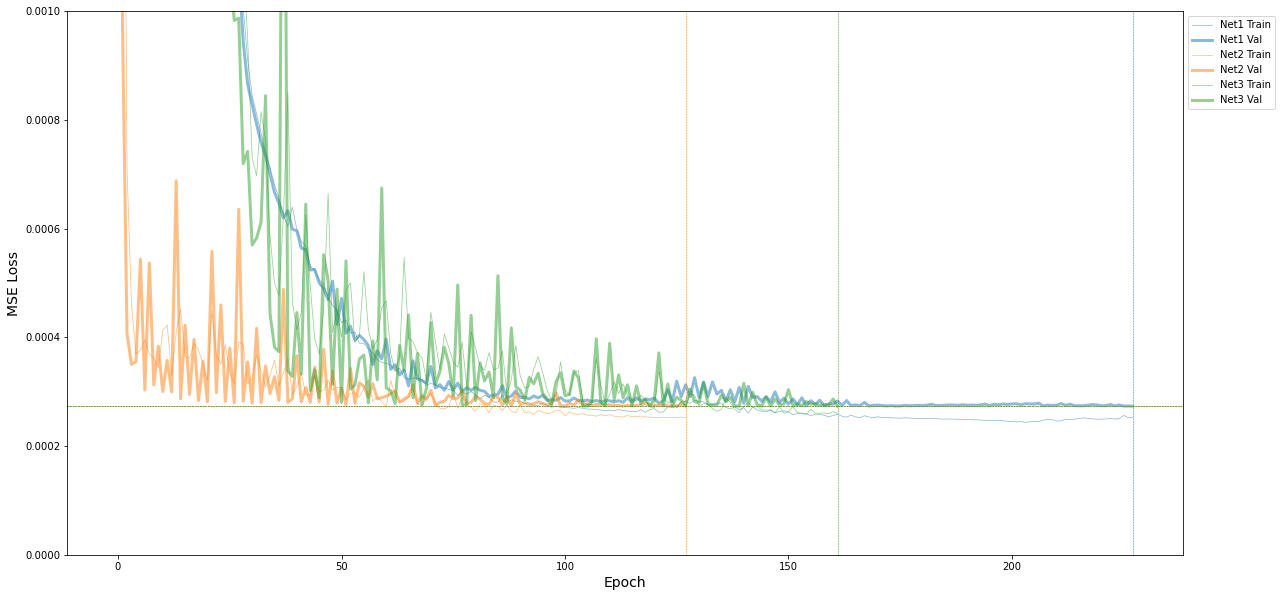

In [45]:
nets = [
    (net_regr1,'Net1'),
    (net_regr2,'Net2'),
    (net_regr3,'Net3'),
#     (net_regr4,'Net4'),
#     (net_regr5,'Net5'),
#     (net_regr6,'Net6'),
]

sk_loss_plot(nets)

YTRUE torch.Size([1362, 92])
**** ave r2:     -0.0010380903176193715
**** r2 overall: -0.0010380904539910585
YTRUE torch.Size([341, 92])
**** ave r2:     -0.007575563084478163
**** r2 overall: -0.007575564135639407


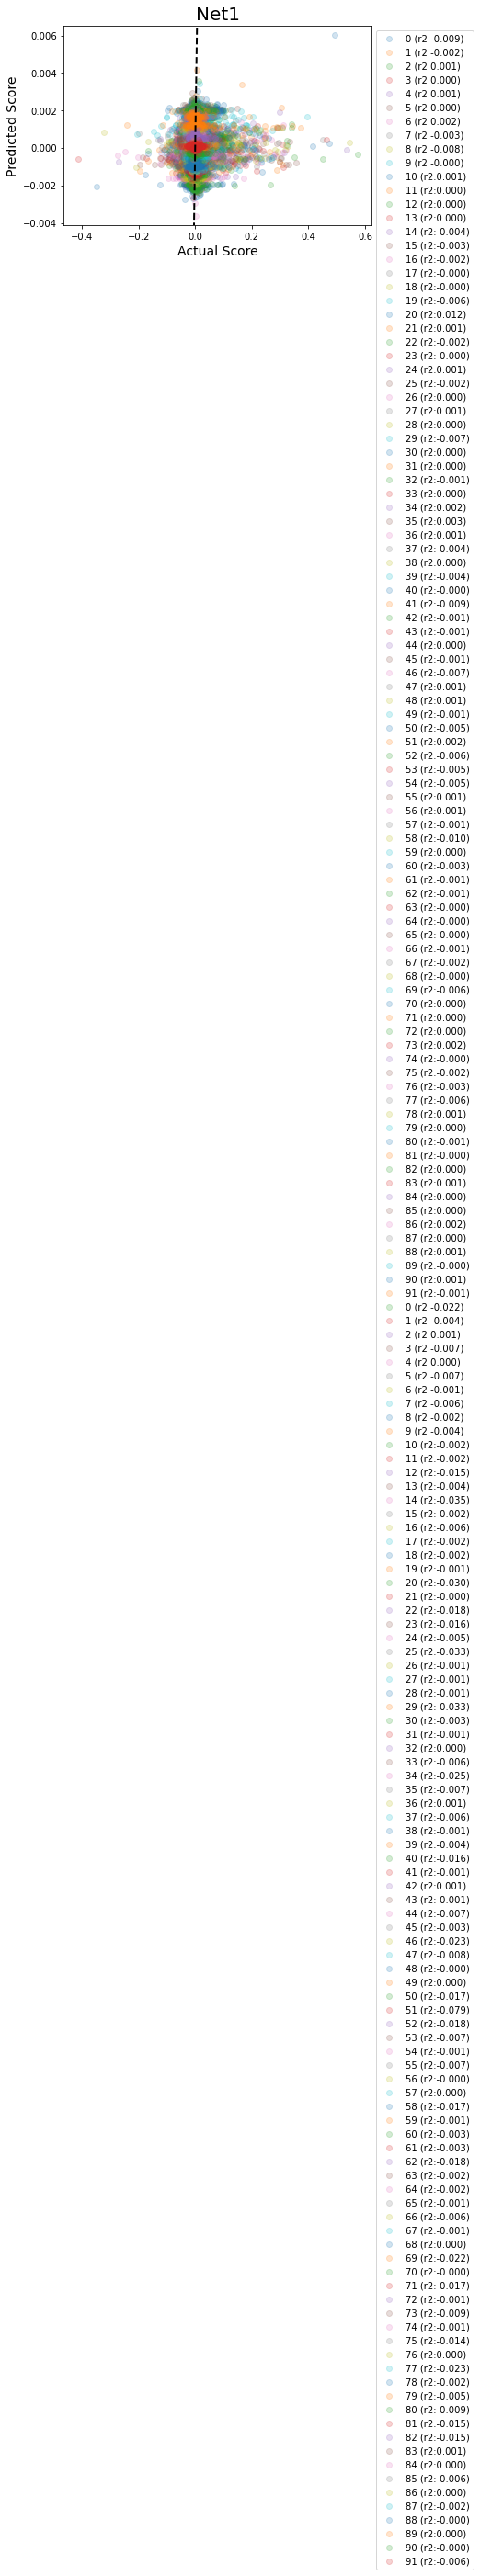

YTRUE torch.Size([1362, 92])
**** ave r2:     0.0017432866205190887
**** r2 overall: 0.001743286488952552
YTRUE torch.Size([341, 92])
**** ave r2:     -0.0066224349760883785
**** r2 overall: -0.006622436008458388


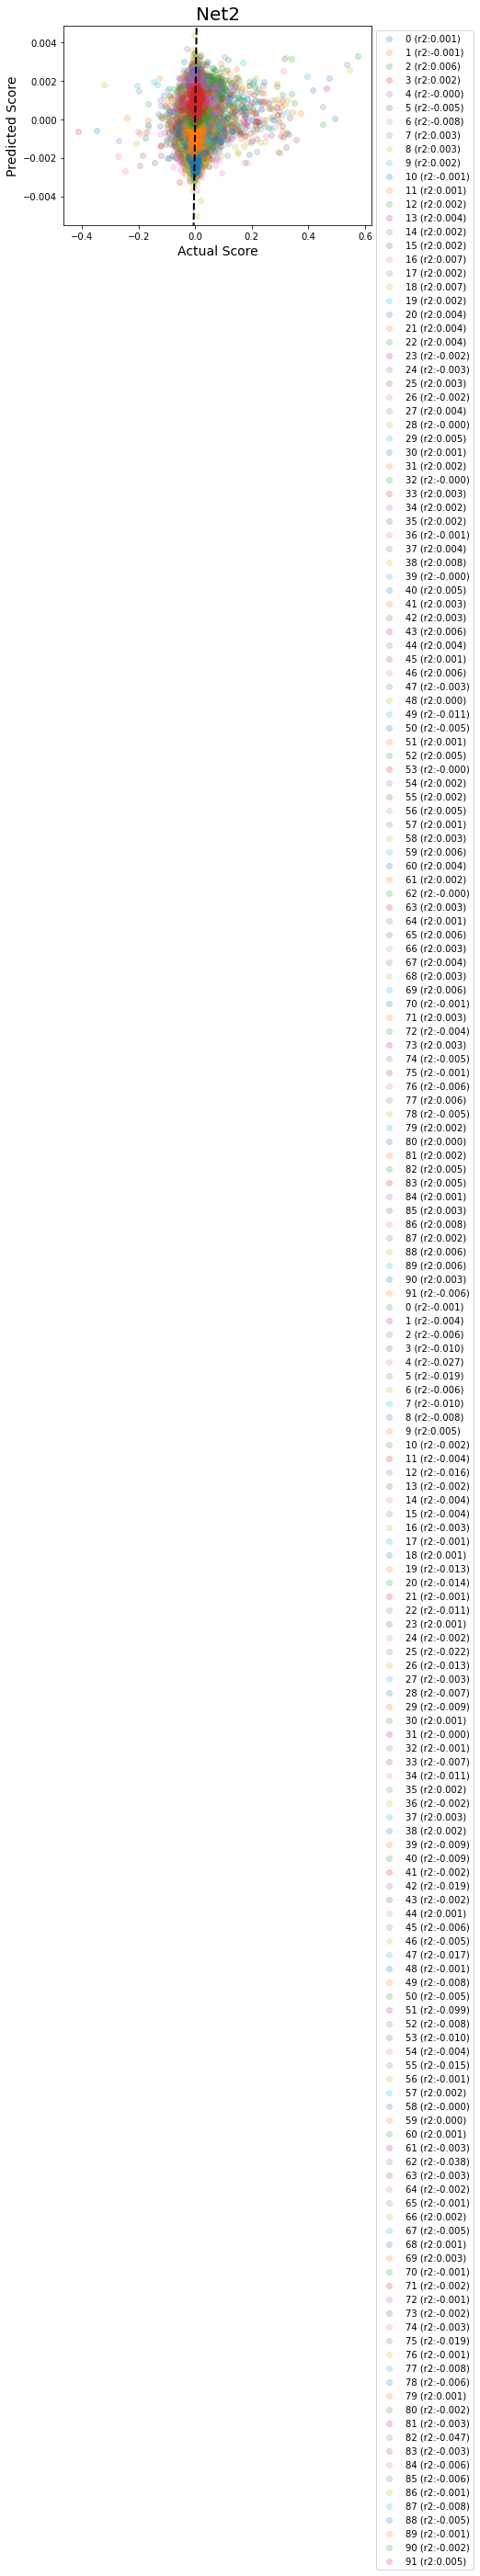

YTRUE torch.Size([1362, 92])
**** ave r2:     -5.933932408378038e-05
**** r2 overall: -5.933946030151796e-05
YTRUE torch.Size([341, 92])
**** ave r2:     -0.006712021695188625
**** r2 overall: -0.006712022735263268


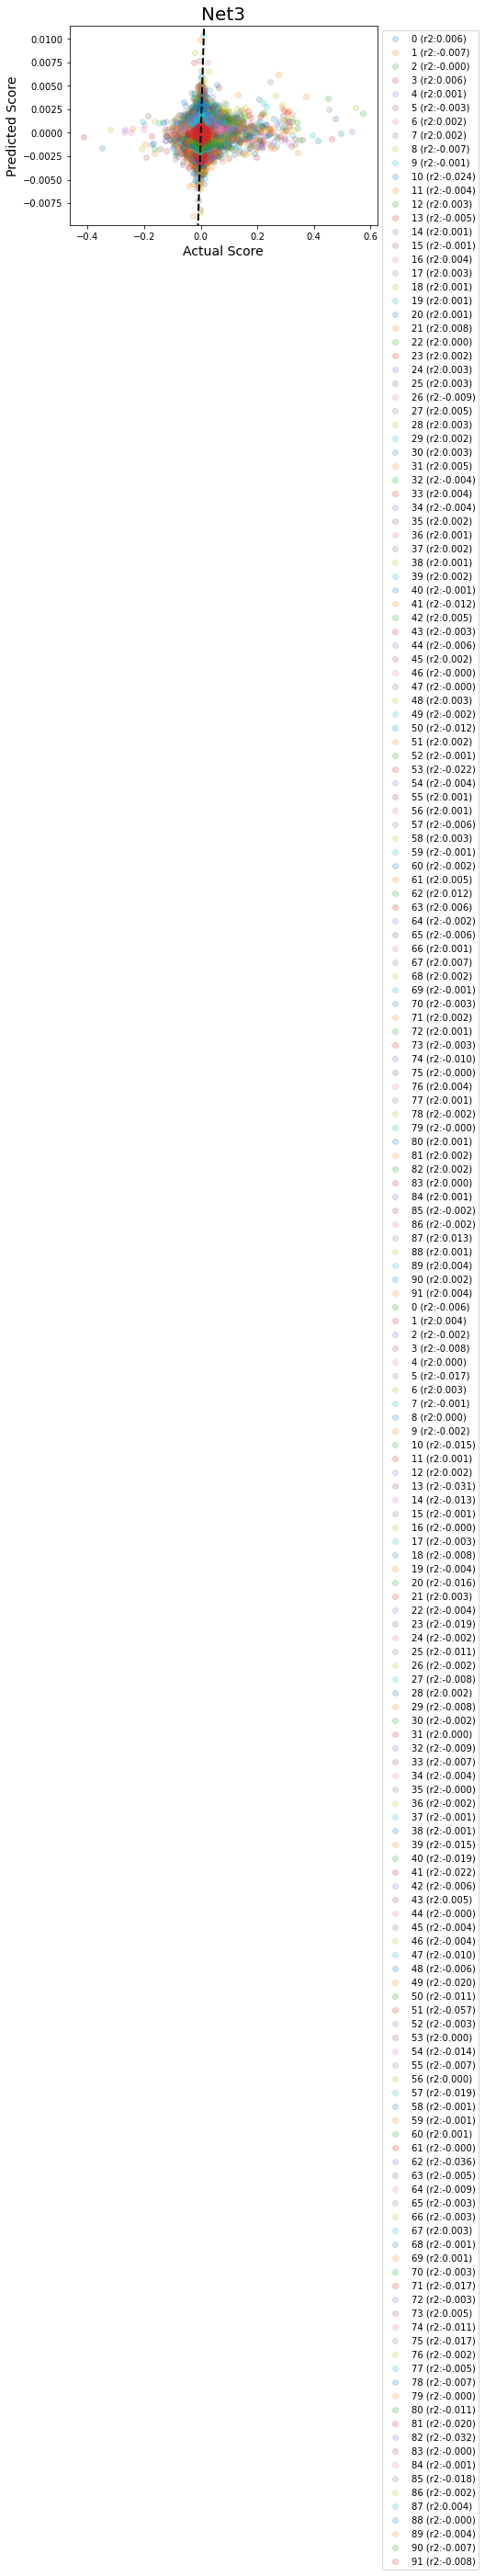

In [54]:
def parity_plot_comb(title,true_preds,rigid=False):
    all_net_r2s = []
    for (ytrue, ypred,name) in true_preds:
        print("YTRUE",ytrue.shape)
#         print("YPRED",ypred.shape)
        r2s = []
        for i in range(ytrue.shape[1]):
            ytruei = ytrue[:,i]
            ypredi = ypred[:,i]
            r2i = r2_score(ytruei,ypredi)
            #print(f"r2 {i}", r2i)
            r2s.append(r2i)
            plt.scatter(ytruei, ypredi, alpha=0.2,label=f"{i} (r2:{r2i:.3f})")
            
        r2 = r2_score(ytrue,ypred)
        r2i_mean = np.mean(r2s)
        print(f"**** ave r2:    ", r2i_mean)
        print(f"**** r2 overall:", r2)
        
        #plt.scatter(ytrue, ypred, alpha=0.2,label=f"{name} (r2:{r2:.3f})")
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title}",fontsize=20)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

def view_preds(nets):
    # for each network to plot
    for (net,name) in nets:
        ytrain_pred = net.predict(Xtrain)
        yval_pred = net.predict(Xval)
        
#         print(ytrain_pred.shape)
#         print(yval_pred.shape)

        plot_list = [
            (ytrain,ytrain_pred,"train"),
            (yval,yval_pred,"val"),
        ]
        parity_plot_comb(name, plot_list)


#view_preds(nets[::-1])
view_preds(nets)

In [69]:
def view_multi_parity(title,ytrue,ypred,rigid=False, num_cols=8):
        
    num_plts = ytrue.shape[1]
    num_rows = int(np.ceil(num_plts/num_cols))
    
    max_point = max(max(ytrue.flatten()),max(ypred.flatten()))
    min_point = min(min(ytrue.flatten()),min(ypred.flatten()))
    
    plt.figure(figsize=(15, 20))
    

    for c in range(ytrue.shape[1]):
        
        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols,c+1)
        yt = ytrue[:,c]
        yp = ypred[:,c]
        p = scipy.stats.pearsonr(yt,yp)[0]
        r2 = r2_score(yt,yp)
        
        ax1.scatter(yt,yp,color=f'C{c}',label=c,alpha=0.2)
        #ax1.set_title(f"{cond_dict[c]} (pearsonr:{p:.3f})")
        #ax1.set_title(f"{cond_dict[c]} (p:{p:.3f})")
        ax1.set_title(f"{c} (r2:{r2:.3f})")
        if rigid:
            plt.ylim(min_point,max_point)
        ax1.plot([min_point,max_point], [min_point,max_point], linestyle='--', color='k', lw=2, scalex=False, scaley=False)
        #plt.xlabel("Actual Value")
        #plt.ylabel("Predicted Value")
    plt.suptitle(title,fontsize=22)
    
    plt.tight_layout()

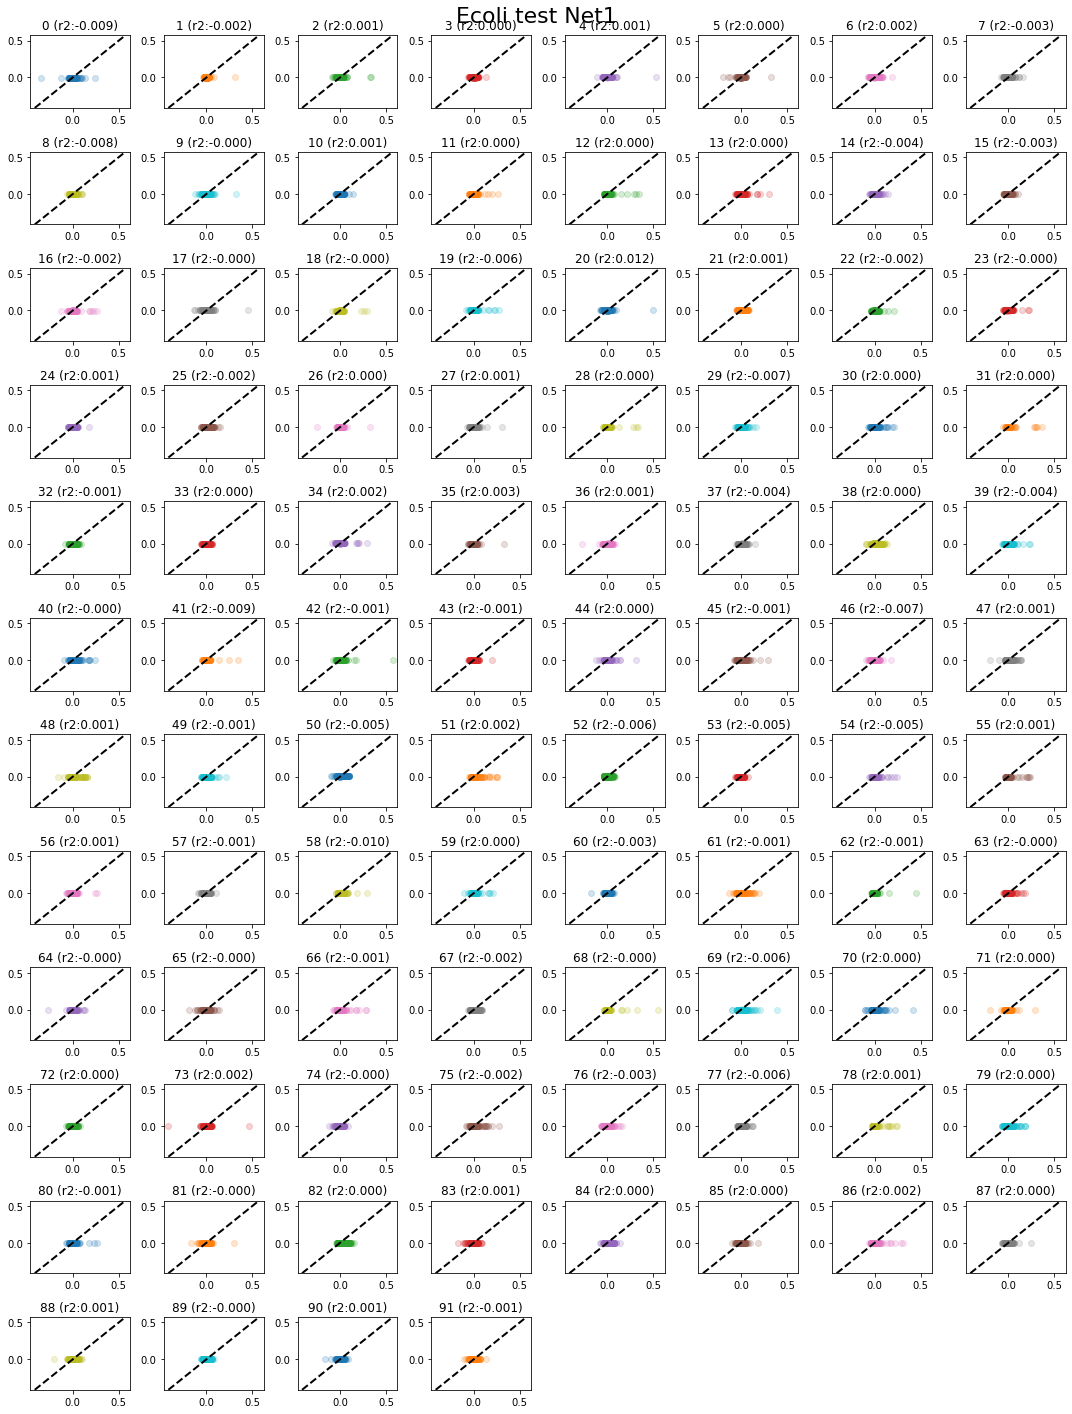

In [70]:
ytrain_pred = net_regr1.predict(Xtrain)
    

view_multi_parity("Ecoli test Net1", 
    ytrain, 
    ytrain_pred,
    rigid=True)

For all tasks, overfitting to "not in iModulon"
* are any iMods better than others?
* do an initial skorch search to see if any hyperparams stand out?
* then dip back to data aug... cross val
* mbinarized



# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one